In [ ]:
!pip install --user stg 
# If you are running this notebook on Google Colab, please reset the current python environment via 'Runtime -> Restart runtime' after installation.

In [39]:
from stg import STG
import numpy as np
import torch
import scipy.stats # for creating a simple dataset 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
# Create a simple dataset
def create_sin_dataset(n,p):
    x1=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    x2=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    y=np.sin(x1)*np.cos(x2)**3
    relevant=np.hstack((x1,x2))
    noise_vector = scipy.stats.norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    return data, y.astype(np.float32)

n_size = 1000 #Number of samples
p_size = 20   #Number of features
X_data, y_data=create_sin_dataset(n_size,p_size)
print(X_data.shape)
print(y_data.shape)

(1000, 20)
(1000, 1)


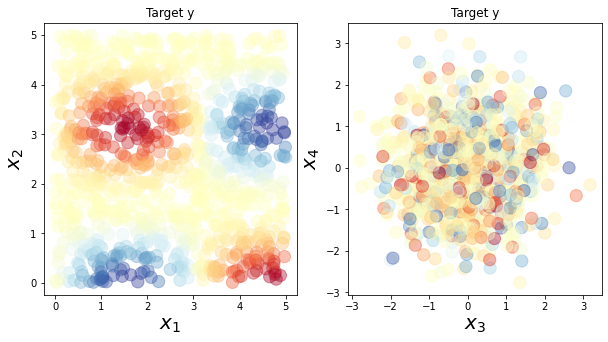

In [3]:
f,ax = plt.subplots(1,2,figsize=(10,5))
        

ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:,2], y=X_data[:,3], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].set_xlabel('$x_3$',fontsize=20)
ax[1].set_ylabel('$x_4$',fontsize=20)
ax[1].set_title('Target y')
plt.tick_params(labelsize=10)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.9)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

In [20]:
args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu") 
feature_selection = True
model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device) 

In [21]:
#model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
#            optimizer='SGD', learning_rate=1e-1, batch_size=X_train.shape[0], sigma=0.5, lam=0.1, random_state=1)

In [22]:
model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_valid, valid_y=y_valid, print_interval=1000)

Epoch: 1000: loss=0.113855 valid_loss=0.051407
Epoch: 2000: loss=0.106771 valid_loss=0.073202
Epoch: 3000: loss=0.040412 valid_loss=0.009950


In [23]:
import torch 
tmp_loss = torch.nn.MSELoss() 
tmp_loss(torch.Tensor(y_train), torch.Tensor(model.predict(X_train)))

tensor(0.0100)

In [24]:
tmp_loss(torch.Tensor(y_test), torch.Tensor(model.predict(X_test))) 

tensor(0.0112)

In [30]:
model.get_gates(mode='prob') 

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [31]:
model.get_gates(mode='raw')

array([ 1.7086443 ,  1.6594719 , -0.8334288 , -0.89889383, -0.8884883 ,
       -0.89185536, -0.8058318 , -0.8775443 , -0.8839916 , -0.8498005 ,
       -0.849079  , -0.9003836 , -0.8719843 , -0.87200505, -0.8806133 ,
       -0.8673934 , -0.8908739 , -0.88513   , -0.882708  , -0.88250214],
      dtype=float32)

## Testing the model

In [32]:
y_pred=model.predict(X_data)

In [33]:
y_pred.shape

(1000, 1)

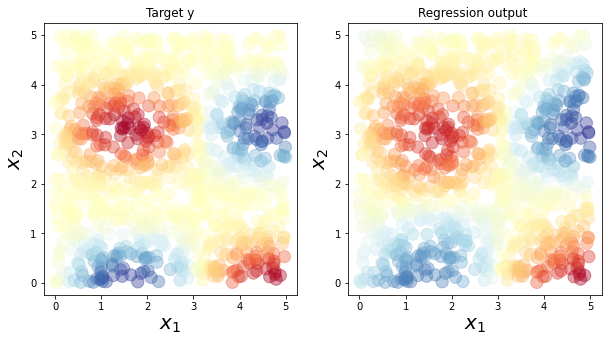

In [34]:
f,ax = plt.subplots(1,2,figsize=(10,5))
        

ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:,0], y=X_data[:,1], s=150, c=y_pred.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].set_xlabel('$x_1$',fontsize=20)
ax[1].set_ylabel('$x_2$',fontsize=20)
ax[1].set_title('Regression output ')
plt.tick_params(labelsize=10)

## Model saving / loading

In [36]:
model.save_checkpoint('trained_model.pt')

In [37]:
model_tmp = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device) 

In [38]:
model_tmp.load_checkpoint('trained_model.pt')

Checkpoint loaded: trained_model.pt.
